##**MSc in Data Science and Economics**
*University of Milan*\
Antonella D'Amico (**961150**)

---



In [1]:
!pip install text2emotion
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 914 kB/s 
     |████████████████████████████████| 175 kB 34.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=d6665deb264e8ca8e56225b2afa055039419b1a0fddae12badcae78e053aa071
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 6.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
import pandas as pd 
import numpy as np 
from unidecode import unidecode

# Text Cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Emotion Analysis 
import text2emotion as te

# POS tagging 
from collections import Counter
nltk.download('averaged_perceptron_tagger')

# VADER generation 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Plot
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Functions

In [4]:
def emotion_detection(sents):
    """Main algo for convertion for the 5 emotions """
    sent_emotion = te.get_emotion(sents) # prende il testo 
    return sent_emotion

In [5]:
# Generating the Emotions 
def generate_emotions(data_dup):
    
    """Use to generate the dataframe that appends the orginal text and the emotion label vector"""
    
    emotion_list = []
    for i, row in data_dup.iterrows():
        emotion_dict = emotion_detection(row[5])
        emotion_dict['Text_cleaned'] = row[5] 
        emotion_list.append(emotion_dict)
        
        
    emotion_df = pd.DataFrame(emotion_list)
    emotion_df = emotion_df.reset_index()
    data_dup = data_dup.reset_index()
    horizontal_stack = data_dup.merge(emotion_df, how='inner', on='index')
      
            
    return horizontal_stack

In [6]:
def generate_pos_tag(df_emotion): # gli diamo in pasto il df ottenuto dalla funzione generate_emotion (emp_df)

  emotion_text = list(df_emotion['Text_cleaned']) # crea una lista con dentro tutti i testi già puliti precedentemente, infatti sono nella colonna 'clean'

  counts = [] # lista vuota che conterrà i conteggi

  for sentence in emotion_text: #sentence è la singola frase contenuta nella lista
     token = nltk.word_tokenize(sentence) #tokenizza la frase prendendo ogni singola parola
     tags = nltk.pos_tag(token) #tagga il token con la part of speach
     counts.append(Counter(tag for word, tag in tags)) # serve per creare il df con il postag

     ''' creazione dell pos tag counter featuers e eliminazione dei pos tag rari, ovvero quelli che hanno più del 70% di valori mancanti'''
  df_postag = pd.DataFrame.from_records(counts) # Convert structured or record ndarray to DataFrame.
  df_postag_nonnull = df_postag.loc[:,df_postag.columns[df_postag.isnull().mean() < 0.7]].reset_index() # eliminazione dei pos tag rari
  df_postag_nonnull.fillna(0, inplace = True) # sostituisce i NaN value con 0 inplace= true vuol dire che modifica il df originale senza crearne uno nuovo

  return df_postag_nonnull

VADER FOR SENTIMENT

In [7]:
# generating Vader https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664
def vader_score_generation(emo_pos_df): # emo_pos_df è quello che creiamo con la fz 'generate_pos_tag'
    
    """Generates the vader scores for the dataframe to create neu pos neg tags base on the text """
    sid = SentimentIntensityAnalyzer()
    polarity_Score = emo_pos_df['Text_cleaned'].apply(lambda review: sid.polarity_scores(review)) # calcola il polarity score per ogni frase nel df sul testo pulito
    df_p_scores = polarity_Score.apply(pd.Series).reset_index() # generating the scores and appending it the dataframe end 
    emo_pos_pscore =  emo_pos_df.merge(df_p_scores, left_on='index', right_on='index')
    return emo_pos_pscore

def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros

In [8]:
# viene usata per il plot
def group_pos_features(pos_tagged_df): # quello che otteniamo da vader_score_generation

    #pos_group = ['group_j', 'group_n','group_r','group_v']
    pos_list = ['RB',	'VBN',	'NN',	'JJ', 'VBG', 'VBD', 'NNS', 'VBP']
    delete_pos_list = []
    pos_dict = {}
    for pos_l in pos_list:
      
      if pos_l in pos_tagged_df.columns:
        pos_dict[pos_l] = np.array(list(pos_tagged_df[pos_l]))
        delete_pos_list.append(pos_l)
      else:
        pos_dict[pos_l] = list(zerolistmaker(len(pos_tagged_df)))
      
    #print(np.sum([pos_dict['CC'],pos_dict['CD']] , axis=0))
    pos_tagged_df['group_j'] = pos_dict['JJ']
    
    pos_tagged_df['group_n'] = np.sum([pos_dict['NN'], pos_dict['NNS']], axis=0) 
    
    pos_tagged_df['group_r'] = pos_dict['RB']
    pos_tagged_df['group_v'] =  np.sum([pos_dict['VBD'], pos_dict['VBN'], pos_dict['VBG'],pos_dict['VBP']], axis=0)  

    return pos_tagged_df, delete_pos_list



---




Load back data

In [61]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/data.pkl", "rb") as f:
    data = pickle.load(f)

In [62]:
data_dup = data.copy() # data_dup 

In [63]:
emotion_df = generate_emotions(data_dup)

In [64]:
emotion_df = emotion_df.drop(['Text_cleaned_y'], axis = 1)
emotion_df.rename(columns = {'Text_cleaned_x': 'Text_cleaned'}, inplace = True)

In [65]:
emotion_df

,index,Title,Link,Label,Description,Original,Text_cleaned,Happy,Angry,Surprise,Sad,Fear
0,0,"""Finally got 5G"": Ryan Reynolds shares photo o...",https://dailyhive.com/vancouver/ryan-reynolds-...,1,Vancouver-raised actor Ryan Reynolds shared a ...,"""Finally got 5G"": Ryan Reynolds shares photo o...",vancouver raised actor ryan reynolds shared se...,0.00,0.00,0.33,0.33,0.33
1,1,Death toll from new coronavirus spikes in just...,https://www.livescience.com/china-coronavirus-...,0,death toll from a new coronavirus in China con...,Death toll from new coronavirus spikes in just...,death toll new china continues climb wuhan chi...,0.00,0.00,0.33,0.33,0.33
2,2,The 5G Covid-19 Quackery - Cenerva,https://cenerva.com/the-5g-covid-19-quackery/,0,I say this as I have heard on social media for...,The 5G Covid-19 Quackery - Cenerva I say this ...,say heard social medium forum elsewhere called...,0.00,0.00,0.17,0.17,0.67
3,3,[The epidemiological characteristics of an out...,https://pubmed.ncbi.nlm.nih.gov/32064853/,0,Objective: An outbreak of 2019 novel coronavir...,[The epidemiological characteristics of an out...,objective outbreak novel disease wuhan china s...,0.00,0.00,0.00,0.25,0.75
4,4,"5G, Religion, and Misconceptions in Communicat...",https://journals.usm.ac.id/index.php/the-messe...,0,"di BCE Ndinojuo Pastor Chris Oyakhilome, found...","5G, Religion, and Misconceptions in Communicat...",bce ndinojuo pastor chris oyakhilome founder b...,0.00,0.00,0.25,0.25,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
1157,1157,She says vaccines make you magnetized. This la...,https://ohiocapitaljournal.com/2021/07/14/she-...,0,After a discredited doctor's conspiracy theori...,She says vaccines make you magnetized. This la...,discredited doctor conspiracy theory involving...,0.00,0.00,0.00,0.33,0.67
1158,1158,Fake News: Bill Gates Did NOT Help Fund Patent...,https://leadstories.com/hoax-alert/2020/02/fak...,0,Did billionaire philanthropist and Microsoft c...,Fake News: Bill Gates Did NOT Help Fund Patent...,billionaire philanthropist microsoft founder b...,0.00,0.00,0.50,0.00,0.50
1159,1159,China Wuhan coronavirus: Videos show patients ...,https://www.businessinsider.com/wuhan-coronavi...,1,Wuhan coronavirus patients being transported i...,China Wuhan coronavirus: Videos show patients ...,wuhan patient transported box plastic tube sto...,0.00,0.33,0.00,0.00,0.67
1160,1160,Italy likely to offer third dose of covid vacc...,https://www.wantedinrome.com/news/italy-likely...,0,Covid vaccines to be extended to children in I...,Italy likely to offer third dose of covid vacc...,vaccine extended child italy soon regulatory a...,0.00,0.00,0.25,0.00,0.75


In [66]:
emotion_df = emotion_df.reset_index()

In [67]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/emotion_df.pkl", "wb") as f:
    pickle.dump(emotion_df, f)

In [68]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/emotion_df.pkl", "rb") as f:
    emotion_df = pickle.load(f)

In [69]:
emo_pos_df = generate_pos_tag(emotion_df)

In [70]:
comb_emo_pos_dist =  emotion_df.merge(emo_pos_df, left_on='index', right_on='index')

In [71]:
# genrating vader text 
emo_pos_dist_pscore = vader_score_generation(comb_emo_pos_dist)

In [72]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/emo_pos_dist_pscore.pkl", "wb") as f:
    pickle.dump(emo_pos_dist_pscore, f)

Processing for plots

In [73]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/emo_pos_dist_pscore.pkl", "rb") as f:
    emotional_df_stack = pickle.load(f)

In [74]:
emotional_df_stack

,level_0,index,Title,Link,Label,Description,Original,Text_cleaned,Happy,Angry,...,RB,VBN,NN,VBD,JJ,VBG,neg,neu,pos,compound
0,0,0,"""Finally got 5G"": Ryan Reynolds shares photo o...",https://dailyhive.com/vancouver/ryan-reynolds-...,1,Vancouver-raised actor Ryan Reynolds shared a ...,"""Finally got 5G"": Ryan Reynolds shares photo o...",vancouver raised actor ryan reynolds shared se...,0.00,0.00,...,2.0,1.0,5,2.0,1.0,1.0,0.000,0.833,0.167,0.3400
1,1,1,Death toll from new coronavirus spikes in just...,https://www.livescience.com/china-coronavirus-...,0,death toll from a new coronavirus in China con...,Death toll from new coronavirus spikes in just...,death toll new china continues climb wuhan chi...,0.00,0.00,...,0.0,1.0,7,0.0,5.0,0.0,0.316,0.684,0.000,-0.8126
2,2,2,The 5G Covid-19 Quackery - Cenerva,https://cenerva.com/the-5g-covid-19-quackery/,0,I say this as I have heard on social media for...,The 5G Covid-19 Quackery - Cenerva I say this ...,say heard social medium forum elsewhere called...,0.00,0.00,...,2.0,1.0,6,1.0,3.0,0.0,0.257,0.743,0.000,-0.5423
3,3,3,[The epidemiological characteristics of an out...,https://pubmed.ncbi.nlm.nih.gov/32064853/,0,Objective: An outbreak of 2019 novel coronavir...,[The epidemiological characteristics of an out...,objective outbreak novel disease wuhan china s...,0.00,0.00,...,1.0,0.0,5,0.0,5.0,0.0,0.000,0.827,0.173,0.3182
4,4,4,"5G, Religion, and Misconceptions in Communicat...",https://journals.usm.ac.id/index.php/the-messe...,0,"di BCE Ndinojuo Pastor Chris Oyakhilome, found...","5G, Religion, and Misconceptions in Communicat...",bce ndinojuo pastor chris oyakhilome founder b...,0.00,0.00,...,0.0,0.0,9,2.0,4.0,1.0,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,1157,1157,She says vaccines make you magnetized. This la...,https://ohiocapitaljournal.com/2021/07/14/she-...,0,After a discredited doctor's conspiracy theori...,She says vaccines make you magnetized. This la...,discredited doctor conspiracy theory involving...,0.00,0.00,...,0.0,1.0,8,1.0,0.0,1.0,0.489,0.511,0.000,-0.8225
1158,1158,1158,Fake News: Bill Gates Did NOT Help Fund Patent...,https://leadstories.com/hoax-alert/2020/02/fak...,0,Did billionaire philanthropist and Microsoft c...,Fake News: Bill Gates Did NOT Help Fund Patent...,billionaire philanthropist microsoft founder b...,0.00,0.00,...,0.0,0.0,8,0.0,2.0,0.0,0.000,0.621,0.379,0.6705
1159,1159,1159,China Wuhan coronavirus: Videos show patients ...,https://www.businessinsider.com/wuhan-coronavi...,1,Wuhan coronavirus patients being transported i...,China Wuhan coronavirus: Videos show patients ...,wuhan patient transported box plastic tube sto...,0.00,0.33,...,1.0,1.0,3,0.0,3.0,1.0,0.196,0.804,0.000,-0.2960
1160,1160,1160,Italy likely to offer third dose of covid vacc...,https://www.wantedinrome.com/news/italy-likely...,0,Covid vaccines to be extended to children in I...,Italy likely to offer third dose of covid vacc...,vaccine extended child italy soon regulatory a...,0.00,0.00,...,2.0,0.0,7,1.0,2.0,0.0,0.000,0.909,0.091,0.0772


In [75]:
del emotional_df_stack['compound']

In [76]:
emotional_df_stack_groupped_pos, pos_tags = group_pos_features(emotional_df_stack)

In [77]:
emotional_df_stack_groupped_pos = emotional_df_stack_groupped_pos.loc[:, (emotional_df_stack_groupped_pos != 0).any(axis=0)]

In [78]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/emotional_df_stack_groupped_pos.pkl", "wb") as f:
    pickle.dump(emotional_df_stack_groupped_pos, f)

In [79]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/emotional_df_stack_groupped_pos.pkl", "rb") as f:
    emotional_df_stack = pickle.load(f)

### Plot

In [80]:
# PCA
pca = PCA(n_components=2)
# Extract features
features_description = emotional_df_stack[["Happy", "Angry", "Surprise", "Sad", "Fear",'group_j','group_n','group_r','group_v','neg','neu','pos']]
# Standardize features
features_description = StandardScaler().fit_transform(features_description)

news_pca_components = pca.fit_transform(features_description)
principalDf = pd.DataFrame(data = news_pca_components, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, emotional_df_stack[['Label']]], axis = 1) 

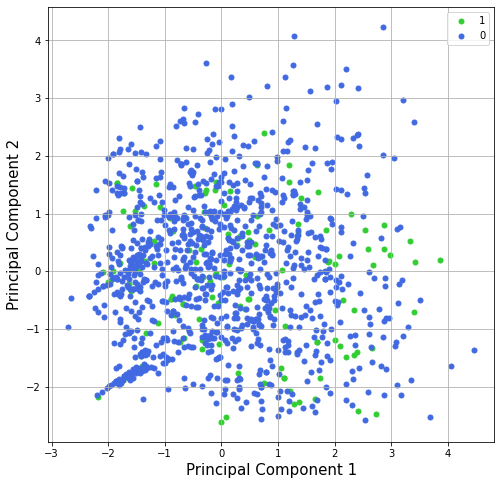

In [81]:
# Plot PCA
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['#32CD32', '#4169E1']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 25)
ax.legend(targets)
ax.grid()
fig.savefig('/content/drive/MyDrive/Master_Thesis_D_Amico/images/PCA.png')



---

## Distribution of fake and real news by emotion and Sentiment

In [82]:
plotting_df_emotion_senti_pso = emotional_df_stack.iloc[:, 7:]

In [83]:
plotting_df_emotion_senti_pso = pd.concat([plotting_df_emotion_senti_pso, emotional_df_stack[['Label']]], axis = 1) 

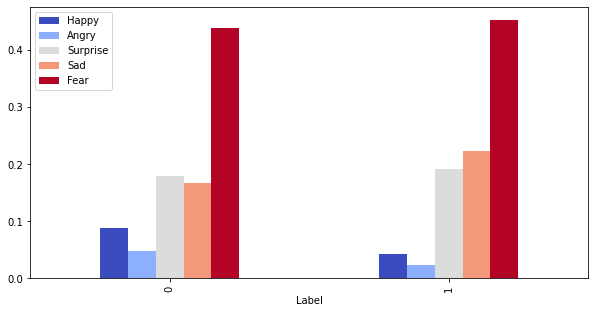

In [84]:
# Distribution of label by emotion 
plotting_df_emotion_senti_pso.groupby('Label').mean().reset_index().plot(figsize=(10, 5),x="Label", y=["Happy", "Angry", "Surprise", "Sad", "Fear"], kind="bar", cmap = 'coolwarm')
plt.savefig('/content/drive/MyDrive/Master_Thesis_D_Amico/images/label_emotion.png')

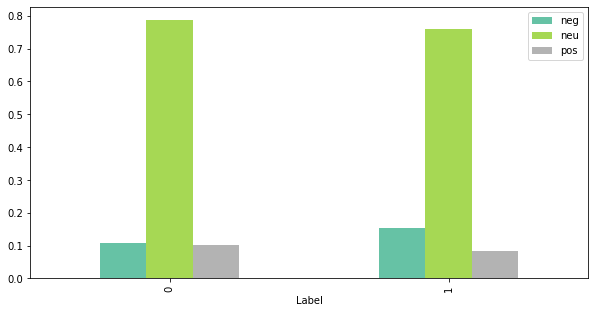

In [85]:
# generating the distribution for Vader tags
vader_tags = ['neg','neu','pos']
plotting_df_emotion_senti_pso.groupby('Label').mean().reset_index().plot(figsize=(10, 5), x="Label", y=vader_tags, kind="bar", cmap = 'Set2')
plt.savefig('/content/drive/MyDrive/Master_Thesis_D_Amico/images/label_sentiment.png')



---



---



## How polarized are the COVID19 related to the description contained in the news article within each topic?

In [47]:
topic_emo = data.copy()
topic_emo = topic_emo.reset_index()
topic_emo.drop(['Title', 'Link', 'Original'],axis=1, inplace=True)

In [48]:
topic_emo = vader_score_generation(topic_emo)

In [49]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/data_topic_dist.pkl", "rb") as f:
    data_topic_dist = pickle.load(f)

In [50]:
data_topic_dist = data_topic_dist.reset_index()

In [51]:
topic_emo_dist = topic_emo.merge(data_topic_dist, how='left')

In [52]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/topic_emo_dist.pkl", "wb") as f:
    pickle.dump(topic_emo_dist, f)

In [56]:
topic_emo_dist.iloc[:, 9:13]

,topic_0,topic_1,topic_2,topic_3
0,0.064815,0.929012,0.003086,0.003086
1,0.002604,0.002604,0.940104,0.054687
2,0.003289,0.595395,0.003289,0.398026
3,0.285211,0.003521,0.707746,0.003521
4,0.002604,0.627604,0.210938,0.158854
...,...,...,...,...
1157,0.126543,0.867284,0.003086,0.003086
1158,0.003086,0.126543,0.003086,0.867284
1159,0.003086,0.003086,0.990741,0.003086
1160,0.990741,0.003086,0.003086,0.003086


In [57]:
topic_emo_dist['Max_topic'] = topic_emo_dist.iloc[:, 9:].idxmax(axis=1) # abbiamo visto ladistrubuzione dei topic per ogni record e abbiamo assegnato un topic centrale che ha la probabilità più alta
topic_emo_dist.update(topic_emo_dist.iloc[:, 9:13].mul(topic_emo_dist.compound, 0)) 

In [58]:
topic_list = ["topic_0", "topic_1", "topic_2", "topic_3"]

for topic in topic_list:
    data = topic_emo_dist[topic_emo_dist.Max_topic == topic]    
    n = len(data)
    av_c = sum(data["compound"])/n
    print("Average compound score of {} for topic {}".format(av_c, topic))

Average compound score of 0.08598625336927217 for topic topic_0
Average compound score of -0.2360623376623377 for topic topic_1
Average compound score of -0.24101583577712615 for topic topic_2
Average compound score of 0.006582191780821916 for topic topic_3


 Abbiamo trovato che i due topic più negativi sono topic 2 (-0.16115875706214705) --> outbreak china  e l'altro negativo è topic 3 (-0.09705896414342623)  dove topic 3 dove topic 0 contiene parole relative al 5g, teorie cospiratrici legate al covid.
quello più positivo è il Topic 3 (0.0986272463768116) --> dove si fa riferimento alle vaccinazioni

In [59]:
def average_compound(data, topic):
    dt = topic_emo_dist[topic_emo_dist.Max_topic == topic]
    fake = dt[dt.Label == 1]
    real = dt[dt.Label == 0]
    
    n_fake = len(fake)
    n_real = len(real)
    av_real = sum(real["compound"])/n_real
    av_fake = sum(fake["compound"])/n_fake
    print("Topic {} diff {}".format(topic, av_real-av_fake))

In [60]:
topic_list = ["topic_0", "topic_1", "topic_2", "topic_3"]
    
for elem in topic_list:
    average_compound(topic_emo_dist, str(elem))
    print(" ")

Topic topic_0 diff 0.2543925252525252
 
Topic topic_1 diff -0.2397447378640778
 
Topic topic_2 diff 0.23729206337509187
 
Topic topic_3 diff 0.25235332633053226
 


Considernado entrambi i compound scores delle real e fake news, la maggior parte dei topic ha in media una sentiment positiva. il topic più negativo è il topic 3 (conspiracy). d'altro canto il topic 2 (china outbreak) mostra una sentiment più positivaa.



---



---

